In [112]:
import pickle
import numpy as np
import copy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# read my pickle
# data = pickle.load(open("individuals_friendships_utilities.p","rb"))
# characteristics, connectivity, utilities = data

g_list = pickle.load(open("g_list.pkl", "rb"))
X_list = pickle.load(open("X_list.pkl", "rb"))
g_simulations = pickle.load(open("simulated_friendships.pkl", "rb"))

In [8]:
# define the data
# make a list of schools trained on, smaller schools not trained on and the simulations
n_0_99 = [1,60,67,68,73,74]
n_100_399 = [0,2,3,4,6,7,16,19,52,69]
n_0_399 = n_0_99 + n_100_399
n_0_399.sort()
schools_0_99 = []
for n in n_0_99:
    schools_0_99.append([g_list[n],X_list[n]])
schools_100_399 = []
for n in n_100_399:
    schools_100_399.append([g_list[n],X_list[n]])
simulations = []
for pos,n in enumerate(n_0_399):
    simulations.append([g_simulations[pos],X_list[n]])
datasets = [schools_0_99,schools_100_399,simulations]

In [19]:
def determine_outdegree(connectivity):
    # this returns the outdegree 
    # and correlation of the outdegree of neighbours

    # total number of connections
    mean_connections = np.sum(connectivity)/len(connectivity)
    # mean corrected connectivity vector
    connectivity_vector = np.zeros(len(connectivity))
    mc_connectivity_vector = np.zeros(len(connectivity))
    for n_student, connections in enumerate(connectivity):
        connectivity_vector[n_student] = np.sum(connections)
        mc_connectivity_vector[n_student] = np.sum(connections)-mean_connections   
    # outdegree correlation matrix for all nodes (so even unconnected)
    outdeg_corr = np.dot(np.transpose([mc_connectivity_vector]),[mc_connectivity_vector])
    # outdegree correlation matrix for neighbours
    neigh_outdeg_corr = outdeg_corr * connectivity
    # mean and standard deviation of the outdegree correlation of neighbours
    mean_outdeg = np.mean(connectivity_vector)
    std_outdeg = np.std(connectivity_vector)
    mean_outdeg_corr = np.mean(neigh_outdeg_corr[np.nonzero(neigh_outdeg_corr)])
    std_outdeg_corr = np.std(neigh_outdeg_corr[np.nonzero(neigh_outdeg_corr)])
    
    return mean_outdeg,std_outdeg,mean_outdeg_corr,std_outdeg_corr

def analyse_network(connectivity, characteristics):
    # OUTPUT:
    # average degree of nodes network            > av_degree
    # density at maximum reach (RCHDEN)          > den_max_reach
    # relative density (RELDEN)                  > rel_den
    # proportion symmetric dyads (PTCMUT)        > p_symm_dyads
    # mutuality index (RHO2)                     > mutuality_index
    # amount of clustering (groups of friends)   > clustering_coefficient  [mean, std dev]
    # homophily index per trait in dict          > homoph_ind              {"0_", "1_", "2_"}
    # segregation index per trait                > segreg_ind              [sex, race, grade]
    
    # INPUT: 
    # - connectivity matrix with row-students nominating column-students as friends
    # - characteristics matrix with row per student, with integers indicating every group for each characteristic (sex, race, grade)
    
    nodes = connectivity.shape[0]
    mutual_d = 0
    asym_d = 0
    #     trait = ["sex", "race", "grade", "school", "_", "_"]
    
    
    #density DENX2
    #DENX2 = np.sum(connectivity)/(nodes*(nodes-1))
    
    
    # density at maximum reach RCHDEN
    
    # define the function to tranfer adjacency matrix to reachability matrix  
    # Prints reachability matrix of graph[][] using Floyd Warshall algorithm 
    # function found on https://www.geeksforgeeks.org/transitive-closure-of-a-graph/
    reachability = copy.deepcopy(connectivity)
    '''reach[][] will be the output matrix that will finally 
    have reachability values. 
    Initialize the solution matrix same as input graph matrix'''
    reach =[i[:] for i in reachability] 
    '''Add all vertices one by one to the set of intermediate 
    vertices. 
    ---> Before start of a iteration, we have reachability value 
    for all pairs of vertices such that the reachability values 
    consider only the vertices in set  
    {0, 1, 2, .. k-1} as intermediate vertices. 
    ----> After the end of an iteration, vertex no. k is 
    added to the set of intermediate vertices and the  
    set becomes {0, 1, 2, .. k}'''
    for k in range(nodes): 
              
        # Pick all vertices as source one by one 
        for i in range(nodes): 
                  
            # Pick all vertices as destination for the 
            # above picked source 
            for j in range(nodes): 
                      
                # If vertex k is on a path from i to j,  
                    # then make sure that the value of reach[i][j] is 1 
                reach[i][j] = reach[i][j] or (reach[i][k] and reach[k][j]) 
    
    RCHDEN = np.sum(reach)/(nodes*(nodes-1))
    
    
    # relative density RELDEN
    RELDEN = np.sum(connectivity)/(10*nodes)


    # create upper triangular matrix with 2's on mutual dyads, 1's on asymmetric dyads and count occurrence
    added_up = np.triu(connectivity + np.transpose(connectivity))
    mutual_d = np.count_nonzero(added_up == 2)
    asym_d = np.count_nonzero(added_up == 1)
    total_d = mutual_d + asym_d
    
    # calculate proportion symmetric dyads (PTCMUT) and asymmetric dyads (PTCASY)
    PTCMUT = mutual_d / total_d
    #PTCASY = asym_d / total_d
    
    
    # count total out_degree connections
    out_degree = connectivity.sum()
    # average out_degree
    av_degree = out_degree / nodes
    # take the sum of squares of the out degree connections per individual (row)
    sum_squares_out = (connectivity.sum(axis=1)**2).sum()
    
    # calculate mutuality index (RHO2) (according to Katz and Powell’s (1955))
    RHO2 = (2*(nodes - 1)**2 * mutual_d - out_degree**2 + sum_squares_out) / (out_degree*(nodes - 1)**2 - out_degree**2 + sum_squares_out)
    
    # determine the local clustering coefficient mean and standard deviation
    clustering_coefficients = []
    for n_node, connections in enumerate(connectivity):
        # the amount of neighbours each node has
        n_neighbours = np.sum(connectivity[n_node])
        # only consider nodes with at least 2 neighbours
        if n_neighbours >= 2:
            # matrix of the nodes that are both neighbours of the node considered
            neighbour_matrix = np.dot(np.transpose([connectivity[n_node]]),[connectivity[n_node]])
            # the amount of connections between neighbours
            neighbour_connections = np.sum(connectivity*neighbour_matrix)
            # the amount of connections between neighbours divided by the possible amount of connections
            clustering_coefficients.append(neighbour_connections / (n_neighbours*(n_neighbours-1)))
    mean_clustering_coefficient = np.mean(clustering_coefficients)
    std_clustering_coefficient = np.std(clustering_coefficients)
    clustering_coefficient = [mean_clustering_coefficient,std_clustering_coefficient]
    
    
    # create homophily index dictionary and lists for the segregation index
    homoph_ind = dict()
    segreg_ind = []
    
    # iterate through different characteristics (sex, race, grade)
    for i in range(characteristics.shape[1]):
        # get different groups of this characteristic in dataset
        # characs = sorted(list(set(characteristics[:,i])))
        characs = sorted(list(set(characteristics.ix[:,i])))
        amount = len(characs)
        
        # counters for individuals per characteristic group and out-group nominations
        charac_count = []
        charac_out = []
        
        # counters for expected and observed cross trait nominations
        exp_cross = 0        
        obs_cross = 0
        
        # iterate through different groups of this characteristic
        for j in range(amount):
            # indicate indices of members this group and save size group
            #indices = np.where(characteristics[:,i] == characs[j])[0]
            indices = np.where(characteristics.ix[:,i] == characs[j])[0]
            charac_count.append(len(indices))
            
            # create a submatrix of all nominations from this group and save amount
            submat_trait = connectivity[np.ix_(indices,)]
            charac_out.append(submat_trait.sum())
            
            # create 2 submatrices outgoing connections: 1 to individuals same group and 1 to individuals different group
            submat_same = connectivity[np.ix_(indices,indices)]
            mask = np.ones(connectivity.shape[0], np.bool)
            mask[indices] = 0
            submat_diff = submat_trait[:,mask]
            
            # count amount outgoing connections to same and to different group
            out_same = np.mean(submat_same.sum(axis=1))
            out_diff = np.mean(submat_diff.sum(axis=1))
            
            # add amount of cross trait nominations of this group to total
            obs_cross += submat_diff.sum()
            
            # calculate and save homophily index from this group for this characteristic
            homoph_ind[str(i) + "_" + str(characs[j])] = out_same / (out_same + out_diff)
        
        # calculate expected cross trait nominations (added for all combinations of traits (except with self))
        for row in range(amount):
            for col in range(amount):
                if row == col: pass
                else:
                    exp_cross += charac_out[row] * ((charac_count[row] * charac_count[col]) / (charac_count[row] * (nodes - 1)))
        
        # calculate and save segregation index for this trait
        if exp_cross == 0:
            segreg_ind.append(999)
            if amount == 1:
                warnings.warn("Just one group: no segregation index for this trait possible.")
            else:
                warnings.warn("Expected cross trait nominations is zero: no segregation index for this trait possible.")
        else:
            segreg_ind.append((exp_cross - obs_cross) / exp_cross)
    
    segreg_ind
    
    return av_degree, RCHDEN, RELDEN, PTCMUT, RHO2, clustering_coefficient, homoph_ind, segreg_ind
    

In [30]:
validation_results = []
for dataset in datasets:
    dataset_netw_vals = []
    for num, school in enumerate(dataset):
        print("analysing school number {}".format(num))
        # store the network characteristics for all schools
        # store the single number variables in a matrix
        number_of_students = len(school[0])
                # OUTPUT analyse_network:    
                # average degree of nodes network            > av_degree
                # density at maximum reach (RCHDEN)          > den_max_reach
                # relative density (RELDEN)                  > rel_den
                # proportion symmetric dyads (PTCMUT)        > p_symm_dyads
                # mutuality index (RHO2)                     > mutuality_index
                # amount of clustering (groups of friends)   > clustering_coefficient  [mean, std dev]
                # homophily index per trait in dict          > homoph_ind              {"0_", "1_", "2_"}
                # segregation index per trait                > segreg_ind              [sex, race, grade]
        average_degree, density_max_reach, relative_density, proportion_symmetric_dyads,mutuality_index,clustering_coefficient,homophily_index,segregation_index= analyse_network(school[0],school[1])
        mean_outdeg,std_outdeg,mean_outdeg_corr,std_outdeg_corr = determine_outdegree(school[0])
        school_characteristics = [number_of_students,average_degree, density_max_reach, relative_density, proportion_symmetric_dyads,mutuality_index,clustering_coefficient[0],clustering_coefficient[1],mean_outdeg,std_outdeg,mean_outdeg_corr,std_outdeg_corr]
        segregation_values = [homophily_index,segregation_index]
        characteristics_matrix = np.array(school_characteristics)
        print("characteristics_matrix=",characteristics_matrix)
        print("segregation_index=",segregation_index)
        school_values = [characteristics_matrix,segregation_values]
        dataset_netw_vals.append(school_values)
    validation_results.append(dataset_netw_vals)

analysing school number 0
characteristics_matrix= [30.          4.          0.77586207  0.4         0.39534884  0.49885405
  0.37473545  0.23610078  4.          2.96647939  2.90654206  8.71836895]
segregation_index= [0.09887005649717526, -0.07617187500000001, 0.29102478231748174, 999]
analysing school number 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: UserWarning: Just one group: no segregation index for this trait possible.


characteristics_matrix= [98.          3.40816327  0.54386703  0.34081633  0.24163569  0.36715645
  0.23419974  0.16621944  3.40816327  2.93757061  2.94907312 10.90333927]
segregation_index= [0.20501529051987763, 0.17248167997375044, 0.6553078476845964, 999]
analysing school number 2
characteristics_matrix= [76.          5.78947368  0.84859649  0.57894737  0.27906977  0.38937005
  0.35812358  0.20450992  5.78947368  2.75927045  1.22350793  6.66634012]
segregation_index= [0.0764656415185007, 0.06605787476280832, 0.6069725972560865, 999]
analysing school number 3
characteristics_matrix= [74.          6.2972973   0.95945946  0.62972973  0.30167598  0.41300022
  0.40015091  0.19809341  6.2972973   2.59797078  0.37663531  5.76591067]
segregation_index= [0.19247787610619466, -0.122909199522103, 0.6565308988764044, 999]
analysing school number 4
characteristics_matrix= [41.          5.19512195  0.81768293  0.5195122   0.3566879   0.4555843
  0.3017306   0.12870966  5.19512195  2.67982082 -0.17

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in double_scalars


characteristics_matrix= [107.           4.           0.58975489   0.4          0.20903955
   0.32027852   0.30674603   0.28432805   4.           2.97654382
   3.43131868   9.7229878 ]
segregation_index= [0.1620736341005372, 0.16237833670617707, 0.46509907529722566, 999]
analysing school number 4
characteristics_matrix= [196.           4.70918367   0.82422815   0.47091837   0.24898512
   0.38384874   0.25396825   0.20707686   4.70918367   2.88771454
   2.47441317   7.85072102]
segregation_index= [0.010524337530539395, 0.23546694442260835, 0.454940023035649, 999]
analysing school number 5
characteristics_matrix= [2.49000000e+02 4.87951807e+00 8.11423112e-01 4.87951807e-01
 2.61682243e-01 4.03087453e-01 2.84119461e-01 2.04805979e-01
 4.87951807e+00 2.93872192e+00 2.45507319e+00 9.30002887e+00]
segregation_index= [0.15403684826368907, 0.47486809219661213, 0.5231437899333026, 999]
analysing school number 6
characteristics_matrix= [2.83000000e+02 5.11307420e+00 8.42944140e-01 5.11307420e-01


In [31]:
# save the validation_results
pickle.dump(validation_results, open("validation_results.pkl", "wb"))

In [101]:
# extract the school size, outdegree, ourgrdree correlation and segregation from the data
n_students_ordered = []
degree_ordered = []
degree_std_ordered = []
correlation_ordered = []
correlation_std_ordered = []
segregation_ordered = []
for n_set,dataset in enumerate(validation_results):
    n_students_s = []
    degree_s = []
    degree_std_s = []
    correlation_s = []
    correlation_std_s = []
    segregation_s = []
    for n_school,school in enumerate(dataset):
        n_students_s.append(validation_results[n_set][n_school][0][0])
        degree_s.append(validation_results[n_set][n_school][0][-4])
        degree_std_s.append(validation_results[n_set][n_school][0][-3])
        correlation_s.append(validation_results[n_set][n_school][0][-2])
        correlation_std_s.append(validation_results[n_set][n_school][0][-1])
        segregation_s.append(validation_results[n_set][n_school][1][1])
    n_students_ordered.append(n_students_s)
    degree_ordered.append(degree_s)
    degree_std_ordered.append(degree_std_s)
    correlation_ordered.append(correlation_s)
    correlation_std_ordered.append(correlation_std_s)
    segregation_ordered.append(np.array(segregation_s))
n_students = np.array(n_students_ordered)
degree = np.array(degree_ordered)
degree_std = np.array(degree_std_ordered)
correlation = np.array(correlation_ordered)
correlation_std = np.array(correlation_std_ordered)

In [94]:
# for the number of students add .5 to the simulated data to make plot readable
n_students[2] = n_students[2]+np.ones(len(n_students[2]))/2

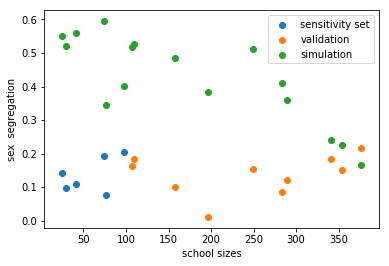

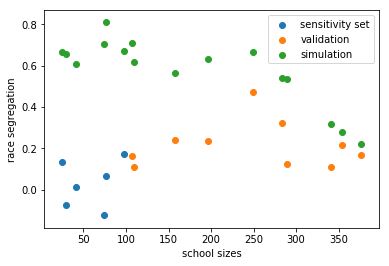

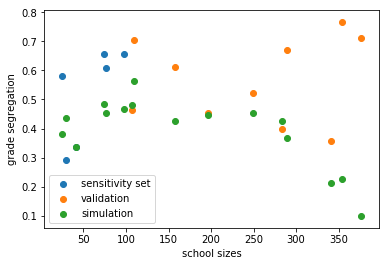

In [131]:
# plot the sex segregation
plt.scatter(n_students[0],list(segregation_ordered[0][:,0]),label="sensitivity set")
plt.scatter(n_students[1],list(segregation_ordered[1][:,0]),label="validation")
plt.scatter(n_students[2],list(segregation_ordered[2][:,0]),label="simulation")
plt.xlabel("school sizes")
plt.ylabel("sex  segregation")
plt.legend()
plt.show()

# plot the race segregation
plt.scatter(n_students[0],list(segregation_ordered[0][:,1]),label="sensitivity set")
plt.scatter(n_students[1],list(segregation_ordered[1][:,1]),label="validation")
plt.scatter(n_students[2],list(segregation_ordered[2][:,1]),label="simulation")
plt.xlabel("school sizes")
plt.ylabel("race segregation")
plt.legend()
plt.show()

# plot the grade segregation
plt.scatter(n_students[0],list(segregation_ordered[0][:,2]),label="sensitivity set")
plt.scatter(n_students[1],list(segregation_ordered[1][:,2]),label="validation")
plt.scatter(n_students[2],list(segregation_ordered[2][:,2]),label="simulation")
plt.xlabel("school sizes")
plt.ylabel("grade segregation")
plt.legend()
plt.show()

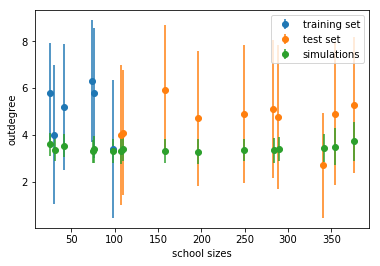

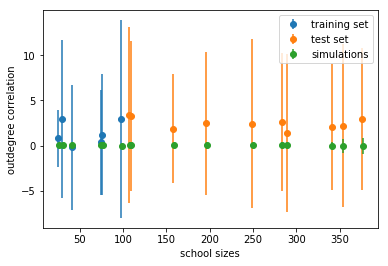

In [97]:
# plot the size of the school vs the outdegree
plt.errorbar(n_students[0],degree[0],yerr=degree_std[0],fmt="o",label="training set")
plt.errorbar(n_students[1],degree[1],yerr=degree_std[1],fmt="o",label="test set")
plt.errorbar(n_students[2],degree[2],yerr=degree_std[2],fmt="o",label="simulations")
plt.xlabel("school sizes")
plt.ylabel("outdegree")
plt.legend()
plt.show()

# plot the size of the school vs the outdegree correlation
plt.errorbar(n_students[0],correlation[0],yerr=correlation_std[0],fmt="o",label="training set")
plt.errorbar(n_students[1],correlation[1],yerr=correlation_std[1],fmt="o",label="test set")
plt.errorbar(n_students[2],correlation[2],yerr=correlation_std[2],fmt="o",label="simulations")
plt.xlabel("school sizes")
plt.ylabel("outdegree correlation")
plt.legend()
plt.show()

In [7]:
print("number_of_students=",number_of_students)
print("average_degree=",average_degree)
print("density_max_reach=",density_max_reach)
print("relative_density=",relative_density) 
print("proportion_symmetric_dyads=",proportion_symmetric_dyads)
print("mutuality_index=",mutuality_index)
print("clustering_coefficient=",clustering_coefficient)
print("homophily_index=",homophily_index)
print("segregation_index=",segregation_index)
print("mean_outdeg=",mean_outdeg)
print("std_outdeg=",std_outdeg)
print("mean_outdeg_corr=",mean_outdeg_corr)
print("std_outdeg_corr=",std_outdeg_corr)

average_degree= 4.10091743119266
density_max_reach= 0.7214576962283384
relative_density= 0.41009174311926605
proportion_symmetric_dyads= 0.2808022922636103
mutuality_index= 0.41640636493060856
clustering_coefficient= [0.32442072614486406, 0.20200116408940086]
homophily_index= {'0_1.0': 0.2644628099173554, '0_2.0': 0.23125, '1_1.0': 0.5327868852459017, '1_3.0': 0.0, '1_5.0': 0.05714285714285714, '2_7.0': 0.13333333333333333, '2_8.0': 0.08955223880597014, '2_9.0': 0.16901408450704225, '2_10.0': 0.12121212121212123, '2_11.0': 0.10769230769230768, '2_12.0': 0.0, '3_0.0': 0.054054054054054064, '3_1.0': 0.5327868852459017, '4_0.0': 0.5734767025089605, '4_1.0': 0.0, '5_0.0': 0.5528455284552845, '5_1.0': 0.05714285714285714}
segregation_index= [-1.3178781129783357, -2.223557692307692, -0.6473337843655823, -2.2814029363784667, -17.77586206896552, -2.522810218978102]
mean_outdeg= 4.10091743119266
std_outdeg= 2.6783020573888945
mean_outdeg_corr= 3.2823350575534005
std_outdeg_corr= 8.2838650759881

In [47]:
validation_first25 = [characteristics_schools,segregation_schools]
pickle.dump(validation_first25, open("validation_first25.pkl", "wb"))